In [1]:
from pylab import *
import random_idx
from __future__ import division
import scipy
import time

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})


height has been deprecated.

2016-10-26 11:38


In [128]:
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_l(M, N=10000, D=27, ares=20000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [3]:
def p_hit(M, N=10000, D=27, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(reject_thresh * N, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

def p_corr_rej(M, N=10000, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N * reject_thresh, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [4]:
def cconv(a, b):
    return real(ifft(fft(a) * fft(b)))
    
def ccinv(a):
    return real(ifft(np.conj(fft(a))))

## Fidelity maximization



So, lets say that we have some fixed set of letters that we want to store/transmit via hypervector. 

In [173]:
D = 16
N = 10000

Ms = 942

letter_vecs = 2*(np.random.randn(D, N) < 0) - 1

signal = np.random.randint(D, size=Ms)


The fidelity is given by $p_{corr}$

In [174]:
pc =  p_correct_l([Ms], N=N, D=D)
print pc, Ms * pc * np.log2(pc*D)

[ 0.90825293] [ 3303.51423912]


So, in this case 

10000


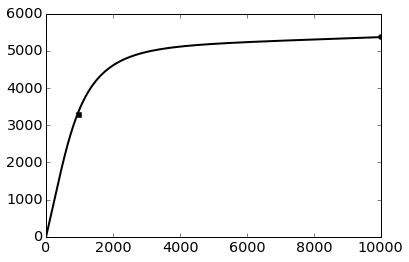

In [175]:
M = arange(N) + 1
pcorr = p_correct_l(M, N=N, D=D)
total_info = M * pcorr * np.log2(pcorr*D)
M_max = M[np.argmax(total_info)]
info_max = total_info.max()

plot(M, total_info, 'k', lw=2)
plot(Ms, Ms * pc * np.log2(pc*D), 'sk', ms=5)
plot(M_max, info_max, 'ok', ms=5)

print M_max

(0, 1.05)

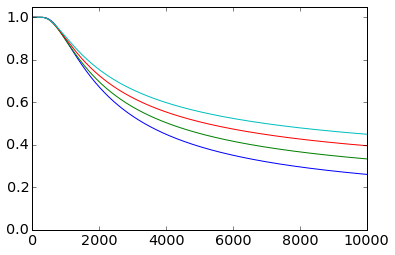

In [176]:
rr_range = range(1,5)

pcc = np.zeros((len(M), len(rr_range) ))
for ri,rr in enumerate(rr_range):
    pcr = p_correct_l(rr*M, N=N, D=D)
    pcc[:, ri] = 1 - (1 - pcr)**rr
    plot(M, pcc[:, ri])
    
ylim([0, 1.05])

(-0.05, 0.05)

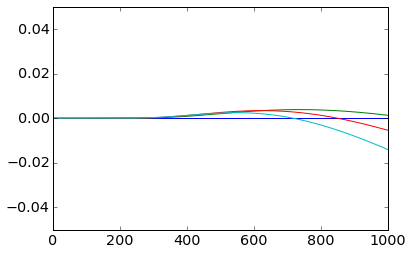

In [177]:
for ri in range(pcc.shape[1]):
    plot(M, pcc[:,0] - pcc[:, ri])
    
#yscale('log')
xlim([0, 1000])
ylim([-0.05, 0.05])

In [178]:
print 2826/3, 1 - (1 - pc)**3

942.0 [ 0.99922772]


So, then by storing and decoding three redundant copies of each hypervector, we can get to the peak of the hypervector's information content and increase the fidelity of each letter.

In [179]:
def test_capacity_redundant(N, D, Ms, redundancy=3):
    letter_vectors = []
    
    for r in range(redundancy):
        letter_vectors.append(2 * (np.random.randn(D, N) > 0) - 1)

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.random.randint(D, size=Ms)
    
    lidx_decode = np.zeros(Ms)

    for i in range(Ms):
        for r in range(redundancy):
            hypercapacity += np.roll(letter_vectors[r][lidx[i],:], i)
        
    for i in range(Ms):
        
        v_decode = np.zeros(D)
        
        for r in range(redundancy):

            #vv = np.dot(letter_vectors, np.roll(hypercapacity, -(i*redundancy + r)))
            vv = np.dot(letter_vectors[r], np.roll(hypercapacity, -i))
            v_decode += vv
            if i == 10:
                plot(vv)
                
        if i == 10:
            plot(v_decode/redundancy, 'k', lw=2)
            title(lidx[i])
        
        lidx_decode[i] = argmax(v_decode)

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_decode

Duration:  0.445146083832


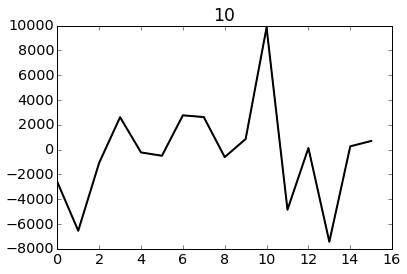

In [180]:
lidx1, lidx1_decode = test_capacity_redundant(N, D, Ms, redundancy=1)


Duration:  0.412281990051
Duration:  2.68590497971
[ 0.89395755] 0.903
[ 0.93945177] 0.89 [ 0.2956919]


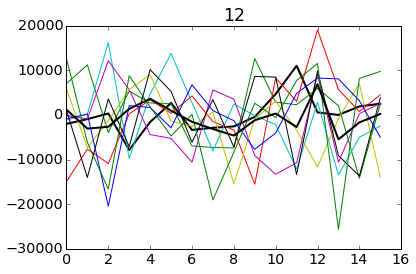

In [181]:
Ms = 1000
rr= 8

lidx1, lidx1_decode = test_capacity_redundant(N, D, Ms, redundancy=1)

lidx3, lidx3_decode = test_capacity_redundant(N, D, Ms, redundancy=rr)

print p_correct_l([Ms], N=N, D=D), np.sum(lidx1 == lidx1_decode) / lidx1.shape[0]
print 1 - (1 - p_correct_l([rr*Ms], N=N, D=D))**rr, np.sum(lidx3 == lidx3_decode) / lidx3.shape[0], p_correct_l([Ms*rr], N=N, D=D)


In [182]:
letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

hypercapacity = np.zeros(N)

tstart = time.time()
lidx = np.random.randint(D, size=Ms)
    
lidx_decode = np.zeros(Ms)

In [ ]:
#test_N = [100, 200, 500]
#test_N = [100, 500, 1000, 5000, 10000]

test_N = [1000, 2000, 4000, 8000, 16000]
runs = 15

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_kanerva_roll(N, len(random_idx.alphabet))
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-kanerva_roll-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N)

In [ ]:
h = np.load('data/hypervector_capacity-kanerva_roll-N=5-r=15-n160517.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
test_N = h['test_N']
run_id = h['run_id']
run_N = h['run_N']
K = 5
runs = len(unique(run_id))

## Plate's Probability Derivations and Comparison

Plate follows a similar strategy of deriving the capacity bounds, but considers a different question. Our analysis diverges after the first step of using Central Limit Theorm to describe hit and reject distributions. Plate's analysis leads to $s_a$ ($a$ for *accept distribution*) and $s_r$ (as in *reject distribution*).

Exactly as our derivation, Plate arrives at 

$$
s_a := \mathscr{N}\left(1, \frac{k+1}{n}\right)
$$
$$
s_r := \mathscr{N}\left(0, \frac{k}{n}\right)
$$

but then Plate's analysis diverges. Plate takes the first step of defining $t$ (which he uses twice, unfortunately, but this is our threshold term), which acts as the threshold and the memory item will be recognized if the dot product exeeds this threshold. Then he defines the term Pr(All Correct):

$$
\begin{split}
Pr(All Correct) &= Pr(Hit)^k Pr(Reject)^{m-k} \\
& = max_t Pr(s_a > t)^k Pr(s_r < t) ^{m-k}
\end{split}
$$

So this is indeed quite a different question than what our analysis considers. Lets translate into code and see how it works. In our terminology: $N=n, M=k, D=m, \theta=t$.

Essential to note is that given the way Plate defined the problem -- a subset of $k$ ($M$) unique elements out of $m$ ($D$) possibilities -- that $k$ ($M$) must be less than $m$ ($D$). Since we used trajectory association, we do not have this issue. 



In [8]:
def p_plate(M, N=10000, D=27, thresh=0.5, ares=2000):
    psa = 1 - ncdf((thresh-1)/((M+1)/N)**0.5)
    psr = ncdf(thresh/((M/N)**0.5))
    
    return psa**M * psr ** (D - M)


First, lets compare Plate's theory to the theory that we derived. The key difference between our results is that Plate found Pr(All Correct), while we found Pr(Correct). However, since the letter decodings are independent, these should be related by simply raising Pr(Correct) to the $M$th power:

$$
Pr(All Correct) = p_{corr}(M)^M
$$

Another issue is that Plate says that there is an ideal threshold for a given set of parameters. I am not going to worry about this ideal threshold and just keep a fixed threshold of 0.5. We can thus compare the results of the two theories.

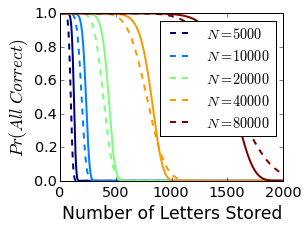

In [62]:

figure(figsize=(4,3))

M = arange(2000)+1
D = 2**12
test_N = [5000, 10000, 20000, 40000, 80000]

cm = get_cmap('jet', len(test_N))

for iN,N in enumerate(test_N):
    plot(M, p_plate(M, N=N, D=D),  '--',lw=2, c=cm(iN), label="$N=%i$" % N)
    plot(M, p_hit(M, N=N, D=D)**M, lw=2, c=cm(iN))
    
legend(loc='upper right')
xlabel('Number of Letters Stored')
ylabel('$Pr(All\ Correct)$')
#title("$D=%i$" % D)

savefig('figures/pr_all_correct-comparison-D=%i-n' % D + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/pr_all_correct-comparison-D=%i-n' % D + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

**Figure 1: Comparison with Plate theory.** Plate derived Pr(All Correct) and this is plotted in solid lines for different values of N with D fixed at 5000. In dashed lines is the new capacity theory raised to the $M$th power to reflect the probability of decoding all letters correctly.



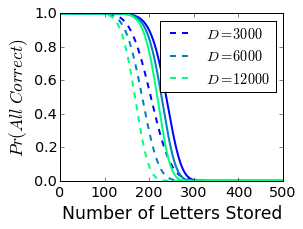

In [136]:

figure(figsize=(4,3))

N = 10000
M = arange(500)+1
test_D = [3000, 6000, 12000]

cm = get_cmap('winter', len(test_D))

for iD,D in enumerate(test_D):
    plot(M, p_plate(M, D=D, N=N),  '--', lw=2, c=cm(iD), label="$D=%i$" % D)
    plot(M, p_hit(M, D=D, N=N)**M, lw=2, c=cm(iD))
    
legend(loc='upper right')
xlabel('Number of Letters Stored')
ylabel('$Pr(All\ Correct)$')
#title("$N = %i$" % N)

savefig('figures/pr_all_correct-comparison-N=%i-n' % N + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/pr_all_correct-comparison-N=%i-n' % N + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

**Figure 2: Comparison with Plate's theory.** Plate's derivation is plotted in solid lines with different values of $D$ and fixed $N$. The new capacity theory is shown in dashed lines.

### Plate's lower bound

Plate also derives in the thesis a lower bound to the capacity equation. He uses an approximation of the error function in a similar fashion to ours. He cites Abramowitz and Stegun (1965) saying:

$$
erfc(x) < \frac{2}{\sqrt{\pi}} e^{-x^2} \frac{1}{x+\sqrt{x^2+4/\pi}}
$$

$$
erfc(x) < \frac{1}{x\sqrt{\pi}}e^{-x^2}
$$

He then uses this relationship to find $q = 1 - Pr(All Correct)$:

$$
\begin{split}
q &= \frac{m}{2} erfc \left( \frac{1}{2} \sqrt{ \frac{n}{2(k+1)} } \right) \\
&< m e^{\frac{-n}{8 (k+1)}}
\end{split}
$$ 

conditional on $\sqrt{ \frac{2(k+1)}{\pi n} } < 1$. (this step isn't exactly clear to me).

And then rearranging:

$$
n < 8(k+1) ln (\frac{m}{q} )
$$

$$
k > \frac{n}{8ln(m/q)} - 1
$$

Translated to our terminology:

$$
N < 8 M [ \log (D-1) - \log (1-p_{all}) ]
$$

This is actually quite close to our derivation in many respects. Let's first review our bound on $p_{corr}$. We use a similar bound stating that:

$$
\Phi(x) > 1 - \frac{1}{2} e ^{ \frac{-x^2}{2} }
$$

which then leads to:

$$
p_{corr} > \left[ 1 - \frac{1}{2} e ^ {\frac{-N}{4M}} \right]^{D-1} \approx e ^ {\frac{D-1}{2} e ^ {-\frac{N}{4M} } }
$$

(I also think that this can be derived using the ideas of the Extreme Value Distribution, and it may be a simpler derivation/argument)

We then solve this equation and take $\epsilon := \log(2(1-p_{corr}))$:

$$
N = 4 M ( \log(D-1) - \epsilon )
$$



In [575]:
h = np.load('data/p_correct-theory-N=12-D=16-n160503.npz')
p_correct = h['p_correct']
test_N = h['test_N']
test_D = h['test_D']

p_tol=1.00000: N = M * ( 3.91 log2(D) + 81.02 )
p_tol=1.00000: N = M * ( 3.80 log2(D) + 45.30 )
p_tol=0.99900: N = M * ( 3.40 log2(D) + 19.52 )
p_tol=0.90000: N = M * ( 2.58 log2(D) + 3.31 )
p_tol=0.70000: N = M * ( 2.09 log2(D) + 0.02 )


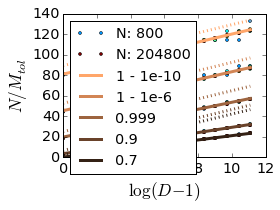

In [576]:
import scipy
from scipy import stats

test_p_tol = [1-1e-10, 1-1e-6, 1-1e-3, 1-1e-1, 1-3e-1]
pc_labels = ['1 - 1e-10', '1 - 1e-6', '0.999', '0.9', '0.7']

figure(figsize=(4,3))

cm = get_cmap('jet', len(test_N))
cmpt = get_cmap('copper', 1.4*len(test_p_tol))

stN=3
p_tol_M = np.zeros((len(test_N), len(test_D), len(test_p_tol)))
slD = np.nan*np.zeros((len(test_N), len(test_p_tol)))
intD = np.nan*np.zeros((len(test_N), len(test_p_tol)))

for ip, p_tol in enumerate(test_p_tol[0:]):
    #for iN,N in enumerate(test_N):
    for iN in range(stN, len(test_N)):
        N = test_N[iN]
        for iD,D in enumerate(test_D):
            m_idx = np.nonzero(np.squeeze(p_correct[iN, iD, :]) < p_tol)[0]
            if len(m_idx) < 1:
                p_tol_M[iN, iD, ip] = N
            else:
                p_tol_M[iN, iD, ip] = m_idx[0]
            
        xD = np.log(np.array(test_D)-1)
        yD = N / p_tol_M[iN, :, ip]
        slD[iN, ip], intD[iN, ip], r, p, err = stats.linregress(xD, yD)
        
        if ip == 0 and (iN==stN or iN==len(test_N)-1):
            plot(xD, yD, 'o', color=cm(iN), ms=3, mec=None, label='N: %i' % N)
        else:
            plot(xD, yD, 'o', color=cm(iN), ms=3, mec=None)
        #plot(xD, slD[iN, ip] * xD + intD[iN, ip], color=cm(iN))
       
    plot(xD, np.nanmean(slD[:,ip]) *xD + np.nanmean(intD[:,ip]), c=cmpt(len(test_p_tol)-ip), lw=3, 
        label=pc_labels[ip])

    
    thD = np.array(test_D)
    eps_tol = 1 - p_tol
    yTheory =  4 * (np.log(thD-1) - np.log(2*eps_tol))
    
    #yfit = 4 * (np.log(thD-1) - 0.9 * np.log(2*eps_tol) - 0.7)
    #yTheory =  - 4 * np.log(sqrt(2*eps_tol/(thD-1)+0.25) -0.5)   
                    
    plot(np.log(thD-1), yTheory,':', c=cmpt(len(test_p_tol)-ip), lw=3)
    #plot(np.log(thD-1), yfit,'-.', c=cmpt(len(test_p_tol)-ip), lw=3)

    print "p_tol=%.5f: N = M * ( %2.2f log2(D) + %2.2f )" % (p_tol, np.nanmean(slD[:,ip]), np.nanmean(intD[:,ip]))

xlabel('$\log (D-1)$')
ylabel('$N/M_{tol}$')
legend(loc='upper left')

plt.tight_layout()

savefig('figures/linear_NMtolD_fit-leg-theory-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/linear_NMtolD_fit-leg-theory-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

**Figure 3: Analytic versus empirical bounds on capacity.** The $p_{corr}$ equation was solved many times and the largest value $M_{tol}$ was found such that $p_{corr} > p_{tol}$ for a given set of parameters. Notably, a precise linear relationship is found for large enough N that tightly links N, M, and D (circles, hotter circles indicate larger N), and the black line indicates a linear fit of the empirically determined values. We use the bound to find an analytic approximation of this linear relationship, shown as blue lines.

So, we can see that our theory does a pretty good job given that is a lower bound (an hence over-estimates the $N$ needed for storing $M_{tol}$ items). The slope of the theoretical lines is also quite close to the slope of the empirical lines for $p_{tol}$ near 1.

p_tol=1.00000: N = M * ( 3.91 log2(D) + 81.02 )
p_tol=1.00000: N = M * ( 3.80 log2(D) + 45.30 )
p_tol=0.99900: N = M * ( 3.40 log2(D) + 19.52 )
p_tol=0.90000: N = M * ( 2.58 log2(D) + 3.31 )
p_tol=0.70000: N = M * ( 2.09 log2(D) + 0.02 )


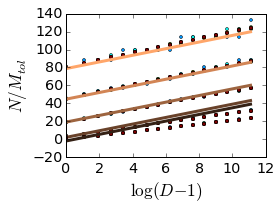

In [620]:
import scipy
from scipy import stats

test_p_tol = [1-1e-10, 1-1e-6, 1-1e-3, 1-1e-1, 1-3e-1]
pc_labels = ['1 - 1e-10', '1 - 1e-6', '0.999', '0.9', '0.7']

figure(figsize=(4,3))

cm = get_cmap('jet', len(test_N))
cmpt = get_cmap('copper', 1.4*len(test_p_tol))

stN=3
p_tol_M = np.zeros((len(test_N), len(test_D), len(test_p_tol)))
slD = np.nan*np.zeros((len(test_N), len(test_p_tol)))
intD = np.nan*np.zeros((len(test_N), len(test_p_tol)))

for ip, p_tol in enumerate(test_p_tol[0:]):
    #for iN,N in enumerate(test_N):
    for iN in range(stN, len(test_N)):
        N = test_N[iN]
        for iD,D in enumerate(test_D):
            m_idx = np.nonzero(np.squeeze(p_correct[iN, iD, :]) < p_tol)[0]
            if len(m_idx) < 1:
                p_tol_M[iN, iD, ip] = N
            else:
                p_tol_M[iN, iD, ip] = m_idx[0]
            
        xD = np.log(np.array(test_D)-1)
        yD = N / p_tol_M[iN, :, ip]
        slD[iN, ip], intD[iN, ip], r, p, err = stats.linregress(xD, yD)
        
        if ip == 0 and (iN==stN or iN==len(test_N)-1):
            plot(xD, yD, 'o', color=cm(iN), ms=3, mec=None, label='N: %i' % N)
        else:
            plot(xD, yD, 'o', color=cm(iN), ms=3, mec=None)
        #plot(xD, slD[iN, ip] * xD + intD[iN, ip], color=cm(iN))
       
    #plot(xD, np.nanmean(slD[:,ip]) *xD + np.nanmean(intD[:,ip]), c=cmpt(len(test_p_tol)-ip), lw=3, 
    #    label=pc_labels[ip])

    
    thD = np.array(test_D)+0.01
    eps_tol = 1 - p_tol
    #yTheory =  4 * (np.log(thD-1) - np.log(2*eps_tol) + 0.5 * np.log(1/(pi)))
    #yTheory =  4 * (np.log(thD-1) - np.log(2*eps_tol) - 0.7)
    yTheory = -4 * np.log(2 * (1 - p_tol ** (1.0/(thD-1))))
    beta = 1.08
    alpha = np.sqrt(2*np.exp(1)/pi)*(np.sqrt(beta-1)/beta)
    
    chang_theory =  4 / beta * (np.log(thD-1) - np.log(2*eps_tol) + np.log(alpha))
    
    #yfit = 4 * (np.log(thD-1) - 0.9 * np.log(2*eps_tol) - 0.7)
    yfit = 4 * (np.log(thD-1) - np.log(2*eps_tol))
    #yTheory =  - 4 * np.log(sqrt(2*eps_tol/(thD-1)+0.25) -0.5)   
                    
    plot(np.log(thD-1), chang_theory,'-', c=cmpt(len(test_p_tol)-ip), lw=3)
    #plot(np.log(thD-1), yfit,'-.', c=cmpt(len(test_p_tol)-ip), lw=3)

    print "p_tol=%.5f: N = M * ( %2.2f log2(D) + %2.2f )" % (p_tol, np.nanmean(slD[:,ip]), np.nanmean(intD[:,ip]))

xlabel('$\log (D-1)$')
ylabel('$N/M_{tol}$')
#legend(loc='upper left')

#title('$N/M = 2 \sqrt{2 \pi / e} ( \log(D-1) - \log(2(1-p_{corr})) + \log(1/\pi)$', fontsize=14)


plt.tight_layout()

savefig('figures/linear_NMtolD_fit-FB-CR-' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/linear_NMtolD_fit-FB-CR-' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [421]:
np.log(1/pi)/2

-0.57236494292470008

p_tol=1.00000: N = M * ( 3.91 log2(D) + 81.02 )
p_tol=1.00000: N = M * ( 3.80 log2(D) + 45.30 )
p_tol=0.99900: N = M * ( 3.40 log2(D) + 19.52 )
p_tol=0.90000: N = M * ( 2.58 log2(D) + 3.31 )
p_tol=0.70000: N = M * ( 2.09 log2(D) + 0.02 )


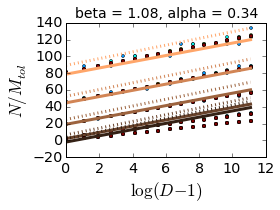

In [472]:
import scipy
from scipy import stats

test_p_tol = [1-1e-10, 1-1e-6, 1-1e-3, 1-1e-1, 1-3e-1]
pc_labels = ['1 - 1e-10', '1 - 1e-6', '0.999', '0.9', '0.7']

figure(figsize=(4,3))

cm = get_cmap('jet', len(test_N))
cmpt = get_cmap('copper', 1.4*len(test_p_tol))

stN=3
p_tol_M = np.zeros((len(test_N), len(test_D), len(test_p_tol)))
slD = np.nan*np.zeros((len(test_N), len(test_p_tol)))
intD = np.nan*np.zeros((len(test_N), len(test_p_tol)))

for ip, p_tol in enumerate(test_p_tol[0:]):
    #for iN,N in enumerate(test_N):
    for iN in range(stN, len(test_N)):
        N = test_N[iN]
        for iD,D in enumerate(test_D):
            m_idx = np.nonzero(np.squeeze(p_correct[iN, iD, :]) < p_tol)[0]
            if len(m_idx) < 1:
                p_tol_M[iN, iD, ip] = N
            else:
                p_tol_M[iN, iD, ip] = m_idx[0]
            
        xD = np.log(np.array(test_D)-1)
        yD = N / p_tol_M[iN, :, ip]
        slD[iN, ip], intD[iN, ip], r, p, err = stats.linregress(xD, yD)
        
        if ip == 0 and (iN==stN or iN==len(test_N)-1):
            plot(xD, yD, 'o', color=cm(iN), ms=3, mec=None, label='N: %i' % N)
        else:
            plot(xD, yD, 'o', color=cm(iN), ms=3, mec=None)
        #plot(xD, slD[iN, ip] * xD + intD[iN, ip], color=cm(iN))
       
    #plot(xD, np.nanmean(slD[:,ip]) *xD + np.nanmean(intD[:,ip]), c=cmpt(len(test_p_tol)-ip), lw=3, 
        #label=pc_labels[ip])

    
    thD = np.array(test_D)
    eps_tol = 1 - p_tol
    
    beta = 1.08
    alpha = np.sqrt(2*np.exp(1)/pi)*(np.sqrt(beta-1)/beta)
    
    chang_theory =  4 / beta * (np.log(thD-1) - np.log(2*eps_tol) + np.log(alpha))
    
    cr_bound =  4  * (np.log(thD-1) - np.log(2*eps_tol))

    #yfit = 4 * (np.log(thD-1) - 0.9 * np.log(2*eps_tol) - 0.7)
    #yTheory =  - 4 * np.log(sqrt(2*eps_tol/(thD-1)+0.25) -0.5)   
                    
    plot(np.log(thD-1), chang_theory,'-', c=cmpt(len(test_p_tol)-ip), lw=3, label=pc_labels[ip])
    plot(np.log(thD-1), cr_bound,':', c=cmpt(len(test_p_tol)-ip), lw=3)
    #plot(np.log(thD-1), yfit,'-.', c=cmpt(len(test_p_tol)-ip), lw=3)

    print "p_tol=%.5f: N = M * ( %2.2f log2(D) + %2.2f )" % (p_tol, np.nanmean(slD[:,ip]), np.nanmean(intD[:,ip]))

xlabel('$\log (D-1)$')
ylabel('$N/M_{tol}$')
#legend(loc='upper left')

title('beta = %2.2f, alpha = %2.2f' % (beta, alpha), fontsize=14)


plt.tight_layout()

savefig('figures/linear_NMtolD_fit-leg-theory_chang11-beta=%2.2f-n' % beta + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/linear_NMtolD_fit-leg-theory_chang11-beta=%2.2f-n' % beta + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [399]:
 np.sqrt(np.exp(1)/pi) 

0.93019136710263284

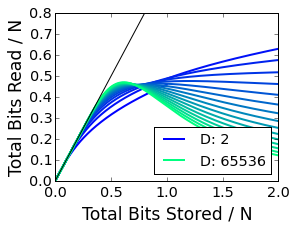

In [165]:
figure(figsize=(4,3))

M = arange(p_correct.shape[2])+1
stN=len(test_N)-1
stD=0
col = get_cmap('winter', len(test_D))
for iN in range(stN, len(test_N)):
    N = test_N[iN]
    for iD in range(stD, len(test_D)):
        D = test_D[iD]
        bits_stored_per_N = M * np.log2(D) / N
        bits_read_per_N = M * p_correct[iN, iD, :] * np.log2(p_correct[iN, iD, :] * D) / N
        
        if iD==stD or iD==len(test_D)-1:
            plot(bits_stored_per_N, bits_read_per_N, color=col(iD), lw=2, label="D: %i" % D)
        else:
            plot(bits_stored_per_N, bits_read_per_N, color=col(iD), lw=2)
        
        
plot([0, 4], [0, 4], 'k')
xlim([0, 2])
ylim([0, 0.8])

xlabel('Total Bits Stored / N')
ylabel('Total Bits Read / N')

legend(loc='lower right')

savefig('figures/total_bits_per_element-lD=' + str(len(test_D)) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/total_bits_per_element-lD=' + str(len(test_D)) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [181]:
# with this function, we are going to try and readout everything in the hypervector each time we add something
def test_capacity_D_totalbits(N, D, bit_factor=1, trials=5e2):
    
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1
    hypercapacity = np.zeros(N)

    tstart = time.time()
    
    bit_ratio = floor(bit_factor / np.log2(D))
    
    lidx = np.zeros(trials * bit_ratio)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    totalbits = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]


        iscorrect = np.zeros(i+1)
        for j in range(i+1):
            v_total = np.roll(hypercapacity, -(i-j))
            iscorrect[j] = float(lidx[j+1] == argmax(np.dot(letter_vectors, v_total.T)))

        #totalbits[t] = (1.0/(1-1.0/D)) * len(iscorrect) * np.log2(D) * (np.mean(iscorrect) - 1.0/D)            
        totalbits[i+1] = len(iscorrect) * np.mean(iscorrect) * log2(np.mean(iscorrect) * D)
        #print np.mean(iscorrect),
        #totalbits[i] = len(iscorrect) * np.log2(D) * (mean(iscorrect))
            
            
    print 'Duration: ', time.time() - tstart
    
    return lidx, totalbits

In [198]:
test_N = [600]
#test_D = [2, 4, 128]
test_D = [2, 8, 2**5, 2**7, 2**9]

#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 10

run_id = []
run_N = []
run_D = []
lidx_all = []
totalbits_all = []
bit_factor=20 # this makes it calculate the storage every 20 bits we add
for r in range(runs):
    print r
    for N in test_N:
        for D in test_D:
            lidx, totalbits = test_capacity_D_totalbits(N, D, bit_factor=bit_factor, trials=N)
        
            run_id.append(r)
            run_N.append(N)
            run_D.append(D)
            lidx_all.append(lidx)
            totalbits_all.append(totalbits)

filename = 'data/hypervector_capacity-totalbits-N=' + str(len(test_N)) + '-D=' + str(len(test_D)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, totalbits_all=totalbits_all, bit_factor=bit_factor,
        run_id=run_id, run_N=run_N, run_D=run_D, runs=runs, test_N=test_N, test_D=test_D)


0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Duration:  1.68043208122
Duration:  2.18396997452
Duration:  4.390832901
Duration:  11.7428429127
Duration:  42.7861058712
1
Duration:  1.95652604103
Duration:  2.52402305603
Duration:  5.07462191582
Duration:  13.2062289715
Duration:  46.0594511032
2
Duration:  1.75199699402
Duration:  2.41358208656
Duration:  4.5467338562
Duration:  11.5600028038
Duration:  40.102107048
3
Duration:  1.59189200401
Duration:  2.16458296776
Duration:  4.42023491859
Duration:  11.7331650257
Duration:  40.6338250637
4
Duration:  1.61860084534
Duration:  2.29652118683
Duration:  4.28524494171
Duration:  11.6830468178
Duration:  41.0373051167
5
Duration:  1.58886003494
Duration:  2.11265707016
Duration:  4.42971301079
Duration:  11.5447878838
Duration:  39.8997879028
6
Duration:  1.6368329525
Duration:  2.16823387146
Duration:  4.2453250885
Duration:  11.6150250435
Duration:  40.3650460243
7
Duration:  1.61273097992
Duration:  2.20566797256
Duration:  4.27736186981
Duration:  11.7783019543
Duration:  45.258

In [ ]:
h = np.load('data/hypervector_capacity-totalbits-N=1-D=5-r=5-n160426.npz')
lidx_all = h['lidx_all']
totalbits_all = h['totalbits_all']

run_id = h['run_id']
run_N = h['run_N']
run_D = h['run_D']
runs = h['runs']
test_N = h['test_N']
test_D = h['test_D']
bit_factor = h['bit_factor']

In [199]:
run_id = np.array(run_id)
run_D = np.array(run_D)

uD = unique(run_D)

tb_all = np.zeros((totalbits_all[0].shape[0], len(uD), runs))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for ii,i in enumerate(idxs):
        tb_all[:,iD,ii] = np.array(totalbits_all[i])
        
tb_mean = np.mean(tb_all, axis=2)

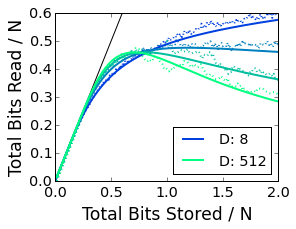

In [258]:
figure(figsize=(4,3))

plot_range = [0,test_N[0]]

M = np.arange(tb_mean.shape[0]) + 1

N = test_N[0]

cm=get_cmap('winter', tb_mean.shape[1])
smoothN=1
#for i in range(1, tb_all.shape[1]):
    #for j in range(tb_all.shape[2]):
        #plot(li_mean[:,i], color=cm(i))    
        #plot(M * np.log2(test_D[i]) / N, tb_all[:,i,j] / N, ':', color=cm(i), lw=1)
        
        
for i in range(1, tb_mean.shape[1]):
    plot(M * np.log2(test_D[i]) / N, tb_mean[:,i] / N, ':', color=cm(i), lw=2)#, label="Mean, D: %5i" % test_D[i])
        

plot(plot_range, plot_range, 'k')
uD = unique(run_D)
uN = unique(run_N)

stD=1
for idxD in range(stD, len(uD)):
    iD = uD[idxD]
    for idxN, iN in enumerate(uN):
        
        #M = np.linspace(1, tb_mean.shape[0], tb_mean.shape[0])
        #subplot(1, len(uD), idxD)
        pp = p_correct_l(M, N=iN, D=iD)
        
        if idxD==stD or idxD==(len(uD)-1):
            plot(np.log2(iD) * M / iN, 
                 #M * np.log2(iD) * (1.0/(1-1.0/iD)) * (p_correct_l2(M, N=iN, D=iD) - 1.0/iD), 
                 M * pp * log2(pp*iD) / iN, '-',
                 color=cm(idxD), lw=2, label="D: %i" % iD)  
        else:
            plot(np.log2(iD) * M / iN, 
                 #M * np.log2(iD) * (1.0/(1-1.0/iD)) * (p_correct_l2(M, N=iN, D=iD) - 1.0/iD), 
                 M * pp * log2(pp*iD) / iN, '-',
                 color=cm(idxD), lw=2)  
            
legend(loc='lower right');
xlabel('Total Bits Stored / N');
ylabel('Total Bits Read / N')
xlim([0, 2])
ylim([0, 0.6])

savefig('figures/total_bits_per_element-validation-lD=' + str(len(uD)) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/total_bits_per_element-validation-lD=' + str(len(uD)) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

Next, we are going to attempt the same type of analysis, but we have to translate to Plate's scenario. Basically, instead of find $M_{tol}$ where the probability of decoding an individual letter of the $M$ letters stored is less than $p_{tol}$, we are going to find $M_{all}$ where the probability of decoding all $M$ letters is less than $p_{all}$. 

We can easily compare this with the new version of the capacity theory by again raising $p_{corr}$ to the $M$th power. 

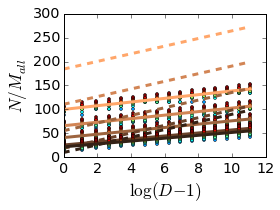

In [101]:
import scipy
from scipy import stats

figure(figsize=(4,3))

#test_p_all = [1-1e-5, 1-1e-3, 1-1e-1, 1-2e-1, 1-3e-1]
test_p_all = [1-1e-10, 1-1e-6, 1-1e-3, 1-1e-1, 1-3e-1]

stN=3
pall_tol_M = np.zeros((len(test_N), len(test_D), len(test_p_tol)))
slD = np.nan*np.zeros((len(test_N), len(test_p_tol)))
intD = np.nan*np.zeros((len(test_N), len(test_p_tol)))

cm = get_cmap('jet', len(test_N))

cmpt = get_cmap('copper', 1.4*len(test_p_tol))

for ip, p_tol in enumerate(test_p_all[0:]):
    #for iN,N in enumerate(test_N):
    for iN in range(stN, len(test_N)):
        N = test_N[iN]
        M = arange(p_correct.shape[2])+1
        for iD,D in enumerate(test_D):
            m_idx = np.nonzero(np.squeeze(p_correct[iN, iD, :]**M) < p_tol)[0]
            if len(m_idx) < 1:
                pall_tol_M[iN, iD, ip] = N
            else:
                pall_tol_M[iN, iD, ip] = m_idx[0]
            
        xD = np.log(np.array(test_D)-1)
        yD = N / pall_tol_M[iN, :, ip]
        slD[iN, ip], intD[iN, ip], r, p, err = stats.linregress(xD, yD)
        
        plot(xD, yD, 'o', color=cm(iN), label="N=%2d" % N, ms=3, mec=None)
    plot(xD, np.nanmean(slD[:,ip]) *xD + np.nanmean(intD[:,ip]), '-', c=cmpt(len(test_p_tol)-ip), lw=3)

    thD = np.array(test_D)
    eps_tol = 1 - p_tol
    yTheory =  8 * (np.log(thD-1) - np.log(eps_tol))
    #    yTheory =  4 * (np.log(thD-1) - np.log(eps_tol))

    #yTheory =  - 4 * np.log(sqrt(2*eps_tol/(thD-1)+0.25) -0.5)   
                    
    plot(np.log(thD-1), yTheory, '--', c=cmpt(len(test_p_tol)-ip), lw=3)
    #print "p_tol=%.5f: N = M * ( %2.2f log2(D) + %2.2f )" % (p_tol, np.nanmean(slD[:,ip]), np.nanmean(intD[:,ip]))

xlabel('$\log (D-1)$')
ylabel('$N/M_{all}$')
plt.tight_layout()

savefig('figures/linear_NMallD_fit-plate_theory-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/linear_NMallD_fit-plate_theory-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

**Figure 4: Relationships based on Pr(All Correct).** The theory was adjusted to Pr(All Correct) by raising $p_{corr}$ to the $M$th power and the largest value $M_{all}$ was found such that $p_{corr} ^ M < p_{all}$. This was found for different tolerances ($p_{all}$) and values for $D$, $N$ and plotted as circles. Dashed lines show linear fits for a given tolerance based on our capacity analysis and solid lines show Plate's lower bound.

Of most importance to note about these lines is that the circles are not directly on top of each other like they are in the previous figure. This means that there isn't an exact linear relationship that relates $\log (D-1)$ with $N/M_{all}$ like there is that relates $\log (D-1)$ with $N/M_{tol}$. You can see the general fact that $N/M_{all}$ is smaller when $N$ is smaller. This is not that surprising, and is just a consequence of finding $Pr(All Correct)$ instead of finding $p_{corr}$. However, the relationhsip is *linear-ish*. 

The Blue lines are then Plate's lower bound theory. These are pretty off, and the slope isn't great. 

Can we get closer to the $M_{all}$ theory? The interesting thing is that the slopes are still basically near 4, just like for $M_{tol}$, but there is an offset difference by about 20.


p_tol=0.99999: N = M * ( 3.68 log2(D) + 57.16 )
p_tol=0.99900: N = M * ( 3.51 log2(D) + 40.79 )
p_tol=0.90000: N = M * ( 3.15 log2(D) + 25.31 )
p_tol=0.80000: N = M * ( 3.07 log2(D) + 22.90 )
p_tol=0.70000: N = M * ( 3.01 log2(D) + 21.46 )


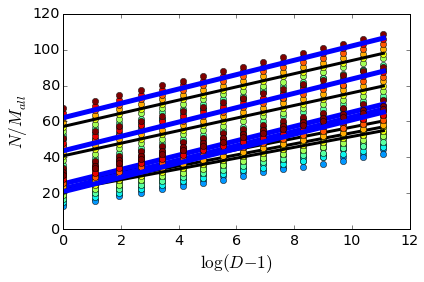

In [14]:
import scipy
from scipy import stats

test_p_all = [1-1e-5, 1-1e-3, 1-1e-1, 1-2e-1, 1-3e-1]

stN=3
pall_tol_M = np.zeros((len(test_N), len(test_D), len(test_p_tol)))
slD = np.nan*np.zeros((len(test_N), len(test_p_tol)))
intD = np.nan*np.zeros((len(test_N), len(test_p_tol)))

cm = get_cmap('jet', len(test_N))
for ip, p_tol in enumerate(test_p_all[0:]):
    #for iN,N in enumerate(test_N):
    for iN in range(stN, len(test_N)):
        N = test_N[iN]
        M = arange(p_correct.shape[2])+1
        for iD,D in enumerate(test_D):
            m_idx = np.nonzero(np.squeeze(p_correct[iN, iD, :]**M) < p_tol)[0]
            if len(m_idx) < 1:
                pall_tol_M[iN, iD, ip] = N
            else:
                pall_tol_M[iN, iD, ip] = m_idx[0]
            
        xD = np.log(np.array(test_D)-1)
        yD = N / pall_tol_M[iN, :, ip]
        slD[iN, ip], intD[iN, ip], r, p, err = stats.linregress(xD, yD)
        
        plot(xD, yD, 'o', color=cm(iN), label="N=%2d" % N)
    plot(xD, np.nanmean(slD[:,ip]) *xD + np.nanmean(intD[:,ip]), 'k', lw=3)

    thD = np.array(test_D)
    eps_tol = 1 - p_tol
    yTheory =  4 * (np.log(thD-1) - np.log(eps_tol) + 4)
    #    yTheory =  4 * (np.log(thD-1) - np.log(eps_tol))

    #yTheory =  - 4 * np.log(sqrt(2*eps_tol/(thD-1)+0.25) -0.5)   
                    
    plot(np.log(thD-1), yTheory, 'b', lw=5)
    print "p_tol=%.5f: N = M * ( %2.2f log2(D) + %2.2f )" % (p_tol, np.nanmean(slD[:,ip]), np.nanmean(intD[:,ip]))

xlabel('$\log (D-1)$')
ylabel('$N/M_{all}$')

plt.tight_layout()

savefig('figures/linear_NMallD_fit-plate_theory-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/linear_NMallD_fit-plate_theory-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

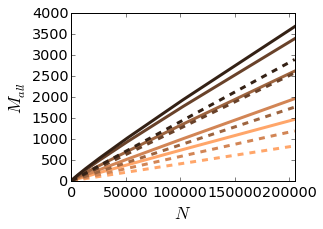

In [102]:
figure(figsize=(4,3))
#test_p_all = [1-1e-10, 1-1e-6, 1-1e-3, 1-1e-1, 1-3e-1]

pc_labels = ['1 - 1e-10', '1-1e-6', '0.999', '0.900', '0.700']

iD = 10
cm = get_cmap('copper', 1.4*len(test_p_all[0:]))
for ip, p_tol in enumerate(test_p_all[0:]):
    #for iN,N in enumerate(test_N):
    #for iD, D in enumerate(test_D):
    plot(test_N, pall_tol_M[:, iD, ip], c=cm(len(test_p_tol)-ip), lw=3)
    
    plate_kb = test_N / (8 * np.log(test_D[iD]/(1-p_tol))) - 1
    plate_ka = test_N / (3.16 * np.log(test_D[iD]/(1-p_tol)**3)) +0.25
    
    plot(test_N, plate_kb, '--', c=cm(len(test_p_tol)-ip), lw=3, label="$p_{all}=% 0.5f$"% p_tol)
    #plot(test_N, plate_ka, c=cm(ip), lw=3)
    
xlim([0, max(test_N)])
ylim([0, 4000])

xlabel('$N$')
ylabel('$M_{all}$')
#title("$D=%i$" % test_D[iD])

#legend(loc='upper left')

savefig('figures/linear_NMall_fit-theory_compare-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/linear_NMall_fit-theory_compare-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

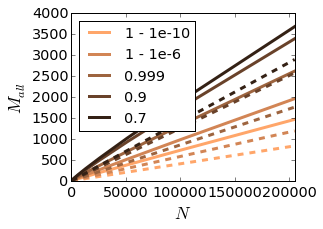

In [108]:
figure(figsize=(4,3))
#test_p_all = [1-1e-10, 1-1e-6, 1-1e-3, 1-1e-1, 1-3e-1]

pc_labels = ['1 - 1e-10', '1 - 1e-6', '0.999', '0.9', '0.7']

iD = 10
cm = get_cmap('copper', 1.4*len(test_p_all[0:]))
for ip, p_tol in enumerate(test_p_all[0:]):
    #for iN,N in enumerate(test_N):
    #for iD, D in enumerate(test_D):
    plot(test_N, pall_tol_M[:, iD, ip], c=cm(len(test_p_tol)-ip), lw=3, label=pc_labels[ip])
    
    plate_kb = test_N / (8 * np.log(test_D[iD]/(1-p_tol))) - 1
    plate_ka = test_N / (3.16 * np.log(test_D[iD]/(1-p_tol)**3)) +0.25
    
    plot(test_N, plate_kb, '--', c=cm(len(test_p_tol)-ip), lw=3)
    #plot(test_N, plate_ka, c=cm(ip), lw=3)
    
xlim([0, max(test_N)])
ylim([0, 4000])

xlabel('$N$')
ylabel('$M_{all}$')
#title("$D=%i$" % test_D[iD])

legend(loc='upper left')

savefig('figures/linear_NMall_fit-leg-theory_compare-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/linear_NMall_fit-leg-theory_compare-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

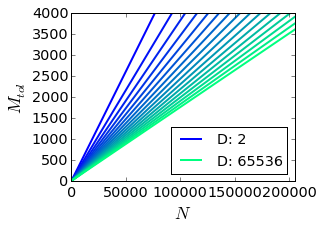

In [135]:
figure(figsize=(4,3))
#test_p_all = [1-1e-10, 1-1e-6, 1-1e-3, 1-1e-1, 1-3e-1]

pc_labels = ['1 - 1e-10', '1 - 1e-6', '0.999', '0.9', '0.7']

iD = 10
cm = get_cmap('winter', len(test_D))
ip=2
#for ip, p_tol in enumerate(test_p_all[0:]):
    #for iN,N in enumerate(test_N):
for iD, D in enumerate(test_D):
    if iD==stD or iD==len(test_D)-1:
        plot(test_N, p_tol_M[:, iD, ip], c=cm(iD), lw=2, label="D: %i" % D)
    else:
        plot(test_N, p_tol_M[:, iD, ip], color=cm(iD), lw=2)
        
    #plate_kb = test_N / (8 * np.log(test_D[iD]/(1-p_tol))) - 1
    #plate_ka = test_N / (3.16 * np.log(test_D[iD]/(1-p_tol)**3)) +0.25
    
    #plot(test_N, plate_kb, '--', c=cm(len(test_p_tol)-ip), lw=3)
    #plot(test_N, plate_ka, c=cm(ip), lw=3)
    
xlim([0, max(test_N)])
ylim([0, 4000])

xlabel('$N$')
ylabel('$M_{tol}$')
#title("$D=%i$" % test_D[iD])

legend(loc='lower right')

savefig('figures/linear_NMtol_fit-leg-theory_compare-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/linear_NMtol_fit-leg-theory_compare-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

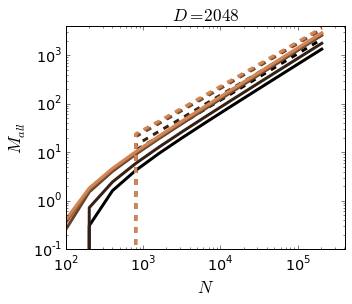

In [16]:
figure(figsize=(5,4))

iD = 10
cm = get_cmap('copper', 1.4*len(test_p_all[0:]))
for ip, p_tol in enumerate(test_p_all[0:]):
    #for iN,N in enumerate(test_N):
    #for iD, D in enumerate(test_D):
    plot(test_N, pall_tol_M[:, iD, ip], '--', c=cm(ip), lw=3)
    
    plate_kb = test_N / (8 * np.log(test_D[iD]/(1-p_tol))) - 1
    plate_ka = test_N / (3.16 * np.log(test_D[iD]/(1-p_tol)**3)) +0.25
    
    plot(test_N, plate_kb, c=cm(ip), lw=3, label="$p_{all}=% 0.5f$"% p_tol)
    #plot(test_N, plate_ka, c=cm(ip), lw=3)
    
xlim([1e2, 2*max(test_N)])
ylim([1e-1, 4000])

xlabel('$N$')
ylabel('$M_{all}$')
title("$D=%i$" % test_D[iD])
xscale('log')
yscale('log')
#legend(loc='upper left')

savefig('figures/linear_NMall_fit-theory_compare-log-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/linear_NMall_fit-theory_compare-log-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

**Figure 5: Linear relationship between $N$ and $M_{all}$.** The linear relationship between $N$ and $M_{all}$ remains, but the approximation Plate derived (solid lines) is quite different from the new capacity theory (dashed lines). 

### Abramowitz and Stegun


crazy stuff

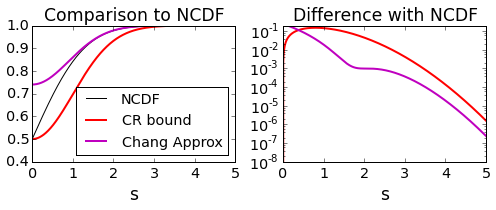

In [533]:

figure(figsize=(7,3))

subplot(121)
xv = linspace(0, 5, 1000)
plot(xv, ncdf(xv), 'k', lw=1, label='NCDF')

def AS_Z(x):
    # just a gaussian
    return 1/(2 * pi) **0.5 * exp(-x**2/2)

# Approximation based on 26.2.16 
p = 0.33267
a1 = 0.4361836
a2 = -0.1201676
a3 = 0.9372980
t = 1/(1+p*xv)

apx26216 = 1 - AS_Z(xv) * (a1*t+a2*t**2+a3*t**3)

#plot(xv, apx26216, '--b', lw=3, label='AS 26.2.16')

# Approximation based on 26.2.18
c1=0.196854
c2=0.115194
c3=0.000344
c4=0.019527
apx26218 = 1 - 0.5 * (1 + c1*xv + c2*xv**2 + c3*xv**3 + c4*xv**4)**(-4)

#plot(xv, apx26218, ':g', lw=3, label='AS 26.2.18')


cr_bound = 1 - 0.5*exp(-xv**2/2)

plot(xv, cr_bound, '-r', lw=2, label='CR bound')

beta = 1.24
alpha = np.sqrt(2*np.exp(1)/pi)*(np.sqrt(beta-1)/beta)
chang_bound = 1 - 0.5 * alpha * exp(-beta*xv**2/2)
plot(xv, chang_bound, 'm', lw=2, label='Chang Approx')


af = 0.7
bf = 0.9
fit_apx = 1 - 0.5 * exp(-1/bf * (xv**2/2 +af))
#plot(xv, fit_apx, 'b', lw=2, label='Fit Approx')

legend(loc='lower right')
title('Comparison to NCDF')
xlabel('s')

subplot(122)
plot(xv, 0*xv, 'k')
plot(xv, np.abs(ncdf(xv) - cr_bound), '-r', lw=2)
plot(xv, np.abs(ncdf(xv) - chang_bound), 'm', lw=2)
#plot(xv, ncdf(xv) - fit_apx, 'b', lw=2)
title('Difference with NCDF')
xlabel('s')

yscale('log')
ylim([1e-8, 0.2])

plt.tight_layout()


savefig('figures/ncdf_approx_compare-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/ncdf_approx_compare-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

## Why the disagreement?

Plate's states that $Pr(All Correct) = Pr(s_a > \theta) ^ M Pr(s_r < \theta) ^ {D - M}$, but this is not exactly right, and is the reason that we have disagreement. 

Based on our theoretical results, we state that:
$$
Pr(All Correct) = p_{corr} ^ M = \left[ \int_\theta^\infty Pr(s_a = h) \left( Pr(s_r < h) \right)^{D-1} dh \right]^M
$$

Plate's probability statement isn't correct because it does not consider all scenarios: e.g. there is a chance that both $s_a$ and one of the $s_r$ values is greater than $\theta$, and the letter can still be classified correctly because we take the maximum as the correct choice. The impact of this scenario and other such scenarios is missing from Plate's theory.

## Information theory comparison

In [667]:
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_l(M, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

def p_correct_snr(M, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        
        snr = (N / Mval)**0.5
        # span the Hit distribution up to 8 standard deviations @todo: make parameter
        avals = np.linspace(1 - 8 / snr, 1 + 8 / snr, ares)
        
        # the discretized gaussian of the hit
        p[:, iM] = ncdf((avals[1:]-1) * snr) - ncdf((avals[:-1]-1) * snr)
        # times the discretized cumulative gaussian of the reject
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0) * snr)) ** (D-1)

    return np.sum(p, axis=0) # integrate over the avals

In [668]:
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_snr(M, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        
        snr = (N / Mval)**0.5
        # span the Hit distribution up to 8 standard deviations @todo: make parameter
        avals = np.linspace(1 - 8 / snr, 1 + 8 / snr, ares)
        
        # the discretized gaussian of the hit
        p[:, iM] = ncdf((avals[1:]-1) * snr) - ncdf((avals[:-1]-1) * snr)
        # times the discretized cumulative gaussian of the reject
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0) * snr)) ** (D-1)

    return np.sum(p, axis=0) # integrate over the avals

In [709]:
N = 10000
M = arange(50000)+1
D = 27 #2**30
s = np.sqrt(N/M)

pc = 1 - 0.5 * (D-1) * exp(-N/(4*M))
pc2 = 1 - 0.5 * (D-1) * exp(-N/(8*M))
beta = 1.08
alpha = np.sqrt(2*np.exp(1)/pi)*(np.sqrt(beta-1)/beta)
pc3 = 1 - 0.5 *(D-1)*alpha * np.exp(-beta * N / (4*M))
pc6 = (1 - 0.5 * alpha * np.exp(-beta * N / (4*M))) ** (D-1)
pc5 = (1 - 0.5 * np.exp(-beta * N / (4*M))) ** (D-1)
pc4 = ncdf(np.sqrt(N/(2*M))) ** (D-1)

    
#pc[pc < 1/D] = 1/D
#pc2[pc2 < 1/D] = 1/D

#pc3 = 1 - 0.5 * D * exp(-1/0.9 * (N/(4*M) + 0.7))
#pc3[pc3 < 1/D] = 1/D

pcorr = p_correct_snr(M, N=N,D=D)

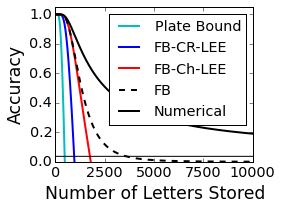

In [738]:
figure(figsize=(4,3))

plot(M, pc2, '-c', lw=2, label='Plate Bound')
#plot(M, pc5, '--b', lw=2, label='FB-CR')
plot(M, pc, '-b', lw=2, label='FB-CR-LEE')
#plot(M, pc6, '--r', lw=2, label='FB-Ch')
plot(M, pc3, '-r', lw=2, label='FB-Ch-LEE')
plot(M, pc4, '--k', lw=2, label='FB')

plot(M, pcorr, '-k', lw=2, label='Numerical')


plot(M, 1/D * np.ones_like(M), 'k')

legend(loc='upper right')
ylabel('Accuracy')
ylim([0, 1.05])
xlabel('Number of Letters Stored')

ax =gca()
ax.set_xticks(arange(0, 10001, 2500))
xlim([0, 10000])


plt.tight_layout()

savefig('figures/accuracy-approx_theory_compare-5-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/accuracy-approx_theory_compare-5-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

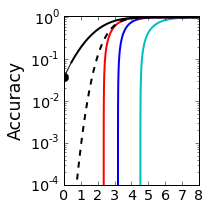

In [737]:
figure(figsize=(3,3))
    
plot(s, pc2, '-c', lw=2, label='Plate Bound')
#plot(s, pc5, '--b', lw=2, label='FB-CR')
plot(s, pc, '-b', lw=2, label='FB-CR-LEE')
#plot(s, pc6, '--r', lw=2, label='FB-Ch')
plot(s, pc3, '-r', lw=2, label='FB-Ch-LEE')
plot(s, pc4, '--k', lw=2, label='FB')

plot(s, pcorr, '-k', lw=2, label='Numerical')

plot([0, s[-1]], [1/D, pcorr[-1]], '-', c=[0, 0, 0], lw=1)
plot(0, 1/D, 'o', c=[0, 0, 0], lw=2, ms=8)


#legend(loc='upper right')
ylabel('Accuracy')
yscale('log')
ylim([1e-4, 1.05])
#xlabel('s')
#xscale('log')
#ax =gca()
#ax.set_xticks([1, 5, 10])
#xlim([0, 1])
xlim([0, 8])


plt.tight_layout()

savefig('figures/accuracy_s-approx_theory_compare-5-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/accuracy_s-approx_theory_compare-5-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [663]:
s.min()

1.0

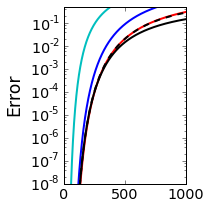

In [729]:
figure(figsize=(3,3))

plot(M, 1-pc2, '-c', lw=2, label='Plate Bound')
#plot(M, 1-pc5, '--b', lw=2, label='FB-CR')
plot(M, 1-pc, '-b', lw=2, label='FB-CR-LEE')
#plot(M, 1-pc6, '--r', lw=2, label='FB-Ch')
plot(M, 1-pc3, '-r', lw=2, label='FB-Ch-LEE')
plot(M, 1-pc4, '--k', lw=2, label='FB')

plot(M, 1-pcorr, '-k', lw=2, label='Numerical')


#legend(loc='lower right')
ylabel('Error')
ylim([1e-8, 0.5])
yscale('log')
#xlabel('Number of Letters Stored')
ax=gca()
ax.set_xticks(arange(0, 1001, 500))
xlim([1, 1000])
#xscale('log')

plt.tight_layout()

savefig('figures/error_log-approx_theory_compare-5-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/error_log-approx_theory_compare-5-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

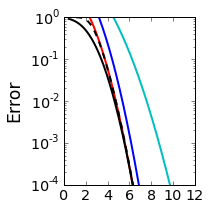

In [730]:
figure(figsize=(3,3))

plot(s, 1-pc2, '-c', lw=2, label='Plate Bound')
#plot(s, 1-pc5, '--b', lw=2, label='FB-CR')
plot(s, 1-pc, '-b', lw=2, label='FB-CR-LEE')
#plot(s, 1-pc6, '--r', lw=2, label='FB-Ch')
plot(s, 1-pc3, '-r', lw=2, label='FB-Ch-LEE')
plot(s, 1-pc4, '--k', lw=2, label='FB')

plot(s, 1-pcorr, '-k', lw=2, label='Numerical')


#legend(loc='lower right')
ylabel('Error')
ylim([1e-4, 1])
yscale('log')
#xlabel('s')
#ax=gca()
#ax.set_xticks(arange(0, 1001, 500))
xlim([0, 12])
#xscale('log')

plt.tight_layout()

savefig('figures/error_log_s-approx_theory_compare-5-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/error_log_s-approx_theory_compare-5-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

1076.57436004 2153.15279623 3080.52191112 4827.31934015


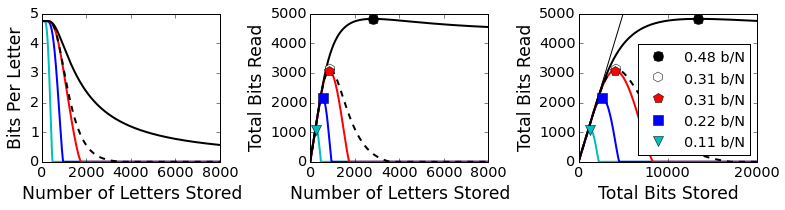

In [736]:
figure(figsize=(11,3))


pM = np.arange(N)+1

ppc = pc[:N].copy()
ppc2 = pc2[:N].copy()
ppc3 = pc3[:N].copy()
ppc4 = pc4[:N].copy()

ppcorr = pcorr[:N].copy()

ppc[ppc<1/D] = 1/D
ppc2[ppc2<1/D] = 1/D
ppc3[ppc3<1/D] = 1/D
ppc4[ppc4<1/D] = 1/D

ax=subplot(131)
plot(ppc2 * np.log2(ppc2*D), '-c', lw=2)
plot(ppc * np.log2(ppc*D), '-b', lw=2)
plot(ppc3 * np.log2(ppc3*D), '-r', lw=2)
plot(ppc4 * np.log2(ppc4*D), '--k', lw=2)
plot(ppcorr * np.log2(ppcorr*D), '-k', lw=2)
ylabel('Bits Per Letter')
xlabel('Number of Letters Stored')

ax.set_xticks(arange(0, 8500, 2000))
xlim([0, 8000])
ax=subplot(132)

plate_app = pM * ppc2 * np.log2(ppc2*D)
CR_app = pM * ppc * np.log2(ppc*D)
Ch_app = pM * ppc3 * np.log2(ppc3*D)
num_lb = pM * ppc4 * np.log2(ppc4*D)
numeric = pM * ppcorr * np.log2(ppcorr*D)

plot(pM, plate_app, '-c', lw=2)
plot(pM, CR_app, '-b', lw=2)
plot(pM, Ch_app, '-r', lw=2)
plot(pM, num_lb, '--k', lw=2)
plot(pM, numeric, '-k', lw=2)

plot(pM[np.argmax(numeric)], numeric.max(), 'ok', ms=10)
plot(pM[np.argmax(num_lb)], num_lb.max(), 'hw', ms=10)
plot(pM[np.argmax(Ch_app)], Ch_app.max(), 'pr', ms=10)
plot(pM[np.argmax(CR_app)], CR_app.max(), 'sb', ms=10)

plot(pM[np.argmax(plate_app)], plate_app.max(), 'vc', ms=10)

print plate_app.max(), CR_app.max(), Ch_app.max(), numeric.max()

ylabel('Total Bits Read')
xlabel('Number of Letters Stored')
ax.set_xticks(arange(0, 8500, 2000))
ylim([0, 5000])
xlim([0, 8000])

ax = subplot(133)

plot([0, 16000], [0, 16000], 'k', lw=1)


plot(pM * np.log2(D), plate_app, '-c', lw=2)
plot(pM * np.log2(D), CR_app, '-b', lw=2)
plot(pM * np.log2(D), Ch_app, '-r', lw=2)
plot(pM * np.log2(D), num_lb, '--k', lw=2)
plot(pM * np.log2(D), numeric, '-k', lw=2)


plot(pM[np.argmax(numeric)]* np.log2(D), numeric.max(), 'ok', ms=10, label='%.2f b/N' % (numeric.max()/N))
plot(pM[np.argmax(num_lb)]* np.log2(D), num_lb.max(), 'hw', ms=10, label='%.2f b/N' % (num_lb.max()/N))
plot(pM[np.argmax(Ch_app)]* np.log2(D), Ch_app.max(), 'pr', ms=10, label='%.2f b/N' % (Ch_app.max()/N))
plot(pM[np.argmax(CR_app)]* np.log2(D), CR_app.max(), 'sb', ms=10, label='%.2f b/N' % (CR_app.max()/N))
plot(pM[np.argmax(plate_app)]* np.log2(D), plate_app.max(), 'vc', ms=10, label='%.2f b/N' % (plate_app.max()/N))

legend(loc='lower right', numpoints=1)

xlabel('Total Bits Stored')
ylabel('Total Bits Read')



ax.set_xticks(arange(0, 42000, 10000))
ylim([0, 5000])
xlim([0, 20000])

plt.tight_layout()

savefig('figures/info-approx_theory_compare-5-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/info-approx_theory_compare-5-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

1076.57436004 2153.15279623 3080.52191112 4827.31934015


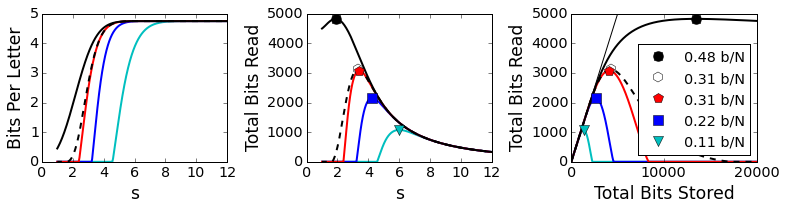

In [735]:
figure(figsize=(11,3))


pM = np.arange(N)+1
ps = np.sqrt(N/pM)

ppc = pc[:N].copy()
ppc2 = pc2[:N].copy()
ppc3 = pc3[:N].copy()
ppc4 = pc4[:N].copy()

ppcorr = pcorr[:N].copy()

ppc[ppc<1/D] = 1/D
ppc2[ppc2<1/D] = 1/D
ppc3[ppc3<1/D] = 1/D
ppc4[ppc4<1/D] = 1/D

ax=subplot(131)
plot(ps, ppc2 * np.log2(ppc2*D), '-c', lw=2)
plot(ps, ppc * np.log2(ppc*D), '-b', lw=2)
plot(ps, ppc3 * np.log2(ppc3*D), '-r', lw=2)
plot(ps, ppc4 * np.log2(ppc4*D), '--k', lw=2)
plot(ps, ppcorr * np.log2(ppcorr*D), '-k', lw=2)
ylabel('Bits Per Letter')
xlabel('s')

#ax.set_xticks(arange(0, 8500, 2000))
xlim([0, 12])
ax=subplot(132)

plate_app = pM * ppc2 * np.log2(ppc2*D)
CR_app = pM * ppc * np.log2(ppc*D)
Ch_app = pM * ppc3 * np.log2(ppc3*D)
num_lb = pM * ppc4 * np.log2(ppc4*D)
numeric = pM * ppcorr * np.log2(ppcorr*D)

plot(ps, plate_app, '-c', lw=2)
plot(ps, CR_app, '-b', lw=2)
plot(ps, Ch_app, '-r', lw=2)
plot(ps, num_lb, '--k', lw=2)
plot(ps, numeric, '-k', lw=2)

plot(ps[np.argmax(numeric)], numeric.max(), 'ok', ms=10)
plot(ps[np.argmax(num_lb)], num_lb.max(), 'hw', ms=10)
plot(ps[np.argmax(Ch_app)], Ch_app.max(), 'pr', ms=10)
plot(ps[np.argmax(CR_app)], CR_app.max(), 'sb', ms=10)

plot(ps[np.argmax(plate_app)], plate_app.max(), 'vc', ms=10)

print plate_app.max(), CR_app.max(), Ch_app.max(), numeric.max()

ylabel('Total Bits Read')
xlabel('s')
#ax.set_xticks(arange(0, 8500, 2000))
ylim([0, 5000])
xlim([0, 12])

ax = subplot(133)

plot([0, 16000], [0, 16000], 'k', lw=1)


plot(pM * np.log2(D), plate_app, '-c', lw=2)
plot(pM * np.log2(D), CR_app, '-b', lw=2)
plot(pM * np.log2(D), Ch_app, '-r', lw=2)
plot(pM * np.log2(D), num_lb, '--k', lw=2)
plot(pM * np.log2(D), numeric, '-k', lw=2)


plot(pM[np.argmax(numeric)]* np.log2(D), numeric.max(), 'ok', ms=10, label='%.2f b/N' % (numeric.max()/N))
plot(pM[np.argmax(num_lb)]* np.log2(D), num_lb.max(), 'hw', ms=10, label='%.2f b/N' % (num_lb.max()/N))
plot(pM[np.argmax(Ch_app)]* np.log2(D), Ch_app.max(), 'pr', ms=10, label='%.2f b/N' % (Ch_app.max()/N))
plot(pM[np.argmax(CR_app)]* np.log2(D), CR_app.max(), 'sb', ms=10, label='%.2f b/N' % (CR_app.max()/N))
plot(pM[np.argmax(plate_app)]* np.log2(D), plate_app.max(), 'vc', ms=10, label='%.2f b/N' % (plate_app.max()/N))

legend(loc='lower right', numpoints=1)

xlabel('Total Bits Stored')
ylabel('Total Bits Read')



ax.set_xticks(arange(0, 42000, 10000))
ylim([0, 5000])
xlim([0, 20000])

plt.tight_layout()

savefig('figures/info-s-approx_theory_compare-5-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/info-s-approx_theory_compare-5-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

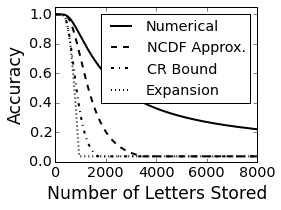

In [563]:
figure(figsize=(4,3))

N = 10000
M = arange(10000)+1
D = 27 #2**30

pc = 1 - 0.5 * D * exp(-N/(4*M))
pc2 = (1 - 0.5 * exp(-N/(4*M)))**D
beta = 1.08
alpha = np.sqrt(2*np.exp(1)/pi)*(np.sqrt(beta-1)/beta)
#pc3 = 1 - 0.5 *D*alpha * np.exp(-beta * N / (4*M))

pc3 =  ncdf(np.sqrt(N/(2*M))) ** D
    
pc[pc < 1/D] = 1/D
pc2[pc2 < 1/D] = 1/D

#pc3 = 1 - 0.5 * D * exp(-1/0.9 * (N/(4*M) + 0.7))
pc3[pc3 < 1/D] = 1/D


pcorr = p_correct_snr(M, N=N,D=D)


plot(M, pcorr, '-k', lw=2, label='Numerical')
plot(M, pc3, '--k', lw=2, label='NCDF Approx.')
plot(M, pc2, '-.k', lw=2, label='CR Bound')
plot(M, pc, ':k', lw=2, label='Expansion')


legend(loc='upper right')
ylabel('Accuracy')
ylim([0, 1.05])
xlabel('Number of Letters Stored')

ax =gca()
ax.set_xticks(arange(0, 8001, 2000))
xlim([0, 8000])


plt.tight_layout()

savefig('figures/accuracy-approx_theory_compare-ncdf-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/accuracy-approx_theory_compare-ncdf-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

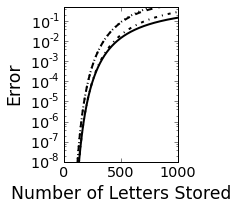

In [564]:
figure(figsize=(3,3))

N = 10000
M = arange(10000)+1
D = 27 #2**30

pc = 1 - 0.5 * (D-1) * exp(-N/(4*M))
pc2 = (1 - 0.5 * exp(-N/(4*M)))**(D-1)
  
pc[pc < 1/D] = 1/D
pc2[pc2 < 1/D] = 1/D

beta = 1.08
alpha = np.sqrt(2*np.exp(1)/pi)*(np.sqrt(beta-1)/beta)
#pc3 = 1 - 0.5 *D*alpha * np.exp(-beta * N / (4*M))
pc3 = ncdf(np.sqrt(N/(2*M)))**(D-1)

#pc3 = 1 - 0.5 * D * exp(-1/0.9 * (N/(4*M) + 0.7))
pc3[pc3 < 1/D] = 1/D

pcorr = p_correct_l(M, N=N,D=D)

plot(M, 1-pc2, '--k', lw=2, label='Plate Bound')
plot(M, 1-pc, ':k', lw=2, label='CR Bound')
plot(M, 1-pc3, '-.k', lw=2, label='Chang Approx.')
plot(M, 1-pcorr, '-k', lw=2, label='Numerical')


#legend(loc='lower right')
ylabel('Error')
ylim([1e-8, 0.5])
yscale('log')
xlabel('Number of Letters Stored')
ax=gca()
ax.set_xticks(arange(0, 1001, 500))
xlim([0, 1000])


plt.tight_layout()

savefig('figures/error_log-ncdf-approx_theory_compare-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/error_log-ncdf-approx_theory_compare-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

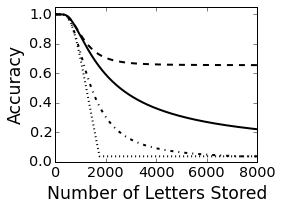

In [565]:
figure(figsize=(4,3))

N = 10000
M = arange(10000)+1
D = 27 #2**30

#pc = 1 - 0.5 * (D-1) * exp(-N/(4*M))
#pc2 = (1 - 0.5 * exp(-N/(4*M)))**(D-1)
beta = 1.08
alpha = np.sqrt(2*np.exp(1)/pi)*(np.sqrt(beta-1)/beta)


pc = 1 - 0.5 *(D-1)*alpha * np.exp(-beta * N / (4*M))
pc2 = (1 - 0.5 *alpha * np.exp(-beta * N / (4*M)))**(D-1)

#pc3 =  ncdf(np.sqrt(N/(2*M))) ** (D-1)
pc3 = 1 - alpha * (1 - ncdf(np.sqrt(N/(2*M))/beta) ** (D-1))
    
pc[pc < 1/D] = 1/D
pc2[pc2 < 1/D] = 1/D

#pc3 = 1 - 0.5 * D * exp(-1/0.9 * (N/(4*M) + 0.7))
pc3[pc3 < 1/D] = 1/D


pcorr = p_correct_snr(M, N=N,D=D)


plot(M, pcorr, '-k', lw=2, label='Numerical')
plot(M, pc3, '--k', lw=2, label='NCDF Approx.')
plot(M, pc2, '-.k', lw=2, label='CR Approx.')
plot(M, pc, ':k', lw=2, label='Expansion.')


#legend(loc='upper right')
ylabel('Accuracy')
ylim([0, 1.05])
xlabel('Number of Letters Stored')

ax =gca()
ax.set_xticks(arange(0, 8001, 2000))
xlim([0, 8000])


plt.tight_layout()

savefig('figures/accuracy-approx_theory_compare-ncdf_chang-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/accuracy-approx_theory_compare-ncdf_chang-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

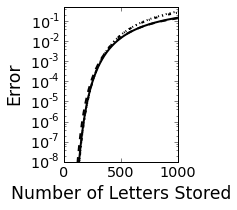

In [566]:
figure(figsize=(3,3))

N = 10000
M = arange(10000)+1
D = 27 #2**30

beta = 1.08
alpha = np.sqrt(2*np.exp(1)/pi)*(np.sqrt(beta-1)/beta)


pc = 1 - 0.5 *(D-1)*alpha * np.exp(-beta * N / (4*M))
pc2 = (1 - 0.5 *alpha * np.exp(-beta * N / (4*M)))**(D-1)

#pc3 =  ncdf(np.sqrt(N/(2*M))) ** (D-1)
pc3 = 1 - alpha * (1 - ncdf(np.sqrt(N/(2*M))/beta) ** (D-1))
    
pc[pc < 1/D] = 1/D
pc2[pc2 < 1/D] = 1/D


#pc3 = 1 - 0.5 * D * exp(-1/0.9 * (N/(4*M) + 0.7))
pc3[pc3 < 1/D] = 1/D

pcorr = p_correct_l(M, N=N,D=D)

plot(M, 1-pcorr, '-k', lw=2)
plot(M, 1-pc3, '--k', lw=2)
plot(M, 1-pc2, '-.k', lw=2)
plot(M, 1-pc, ':k', lw=2)


#legend(loc='lower right')
ylabel('Error')
ylim([1e-8, 0.5])
yscale('log')
xlabel('Number of Letters Stored')
ax=gca()
ax.set_xticks(arange(0, 1001, 500))
xlim([0, 1000])


plt.tight_layout()

savefig('figures/error_log-ncdf_chang-approx_theory_compare-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/error_log-ncdf_chang-approx_theory_compare-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

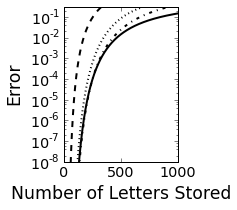

In [567]:
figure(figsize=(3,3))

N = 10000
M = arange(10000)+1
D = 27 #2**30

pc = (1 - 0.5 * exp(-N/(4*M)))**(D-1)
pc2 = 1 - 0.5 * D * exp(-N/(8*M))
pc[pc < 1/D] = 1/D
pc2[pc2 < 1/D] = 1/D

pc3 = 1 - 0.5 * D * exp(-1/0.9 * (N/(4*M) + 0.7))
pc3[pc3 < 1/D] = 1/D

pcorr = p_correct_l(M, N=N,D=D)

plot(M, 1-pc2, '--k', lw=2, label='Plate Approx.')
plot(M, 1-pc, ':k', lw=2, label='New Approx.')
plot(M, 1-pc3, '-.k', lw=2, label='Fit Approx.')
plot(M, 1-pcorr, '-k', lw=2, label='Numerical')


#legend(loc='lower right')
ylabel('Error')
ylim([1e-8, 0.3])
yscale('log')
xlabel('Number of Letters Stored')
ax=gca()
ax.set_xticks(arange(0, 1001, 500))
xlim([0, 1000])


plt.tight_layout()

savefig('figures/error_log-approx_theory_compare-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/error_log-approx_theory_compare-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

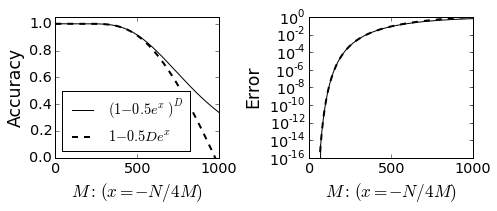

In [376]:
pc_down = (1 - 0.5 * (D-1) * exp(-N/(4*M)))
pc_up = (1 - 0.5 * exp(-N/(4*M))) ** (D-1)


figure(figsize=(7,3))

ax=subplot(121)

plot(M, pc_up, 'k', label="$(1-0.5 e^x)^D$")
plot(M, pc_down, '--k', lw=2, label="$1-0.5 D e^x$")

xlim([0,1000])
ylim([0, 1.05])
ax.set_xticks(arange(0, 1001, 500))
xlabel("$M: \  (x=-N/4M)$")
ylabel('Accuracy')
legend(loc='lower left')

ax=subplot(122)

plot(M, 1-pc_up, 'k')
plot(M, 1-pc_down, '--k', lw=2)

xlabel("$M: \ (x=-N/4M)$")

ylim([1e-16, 1])
yscale('log')
ylabel('Error')
xlim([0,1000])
ax.set_xticks(arange(0, 1001, 500))

plt.tight_layout()

savefig('figures/power_down_approx-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/power_down_approx-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

nan nan 3080.52191112 4974.50350417


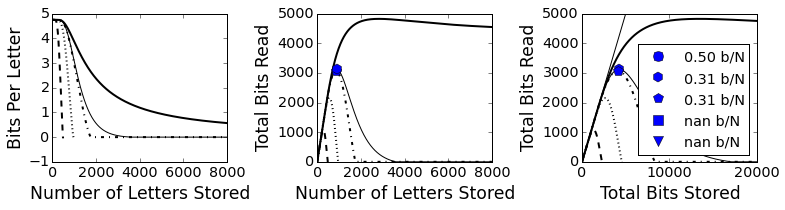

In [707]:
figure(figsize=(11,3))

pc3[pc3<1/D] = 1/D
pc4[pc4<1/D] = 1/D

ax=subplot(131)
plot(pc2 * np.log2(pc2*D), '--k', lw=2)
plot(pc * np.log2(pc*D), ':k', lw=2)
plot(pc3 * np.log2(pc3*D), '-.k', lw=2)
plot(pc4 * np.log2(pc4*D), '-k', lw=1)
plot(pcorr * np.log2(pcorr*D), '-k', lw=2)
ylabel('Bits Per Letter')
xlabel('Number of Letters Stored')

ax.set_xticks(arange(0, 8500, 2000))
xlim([0, 8000])
ax=subplot(132)

plate_app = M * pc2 * np.log2(pc2*D)
sommer_app = M * pc * np.log2(pc*D)
frady_app = M * pc3 * np.log2(pc3*D)
num_lb = M * pc4 * np.log2(pc4*D)
numeric = M * pcorr * np.log2(pcorr*D)

plot(M, plate_app, '--k', lw=2)
plot(M, sommer_app, ':k', lw=2)
plot(M, frady_app, '-.k', lw=2)
plot(M, num_lb, '-k', lw=1)
plot(M, numeric, '-k', lw=2)


plot(M[np.argmax(plate_app)], plate_app.max(), 'vb', ms=10)
plot(M[np.argmax(sommer_app)], sommer_app.max(), 'sb', ms=10)
plot(M[np.argmax(frady_app)], frady_app.max(), 'pb', ms=10)
plot(M[np.argmax(num_lb)], num_lb.max(), 'hb', ms=10)
plot(M[np.argmax(numeric)], numeric.max(), 'ob', ms=10)

print plate_app.max(), sommer_app.max(), frady_app.max(), numeric.max()

ylabel('Total Bits Read')
xlabel('Number of Letters Stored')
ax.set_xticks(arange(0, 8500, 2000))
ylim([0, 5000])
xlim([0, 8000])

ax = subplot(133)
plot(M * np.log2(D), plate_app, '--k', lw=2)
plot(M * np.log2(D), sommer_app, ':k', lw=2)
plot(M * np.log2(D), frady_app, '-.k', lw=2)
plot(M * np.log2(D), num_lb, '-k', lw=1)
plot(M * np.log2(D), numeric, '-k', lw=2)


plot(M[np.argmax(numeric)]* np.log2(D), numeric.max(), 'ob', ms=10, label='%.2f b/N' % (numeric.max()/N))
plot(M[np.argmax(num_lb)]* np.log2(D), num_lb.max(), 'hb', ms=10, label='%.2f b/N' % (num_lb.max()/N))
plot(M[np.argmax(frady_app)]* np.log2(D), frady_app.max(), 'pb', ms=10, label='%.2f b/N' % (frady_app.max()/N))
plot(M[np.argmax(sommer_app)]* np.log2(D), sommer_app.max(), 'sb', ms=10, label='%.2f b/N' % (sommer_app.max()/N))
plot(M[np.argmax(plate_app)]* np.log2(D), plate_app.max(), 'vb', ms=10, label='%.2f b/N' % (plate_app.max()/N))

legend(loc='lower right', numpoints=1)

xlabel('Total Bits Stored')
ylabel('Total Bits Read')

plot([0, 16000], [0, 16000], 'k', lw=1)


ax.set_xticks(arange(0, 42000, 10000))
ylim([0, 5000])
xlim([0, 20000])

plt.tight_layout()

savefig('figures/info-approx_theory_compare-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/info-approx_theory_compare-N=' + str(N) + '-D=' + str(D) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [276]:
10**0.4

2.51188643150958

In [492]:
tst = time.time()

N=1000
M=arange(N*5)+1
test_D=np.logspace(0.3, 6, 100)
#test_D = [2**k for k in range(1, 10)]

M_max_idx = np.zeros_like(test_D)
info_max = np.zeros_like(test_D)
pc_max = np.zeros_like(test_D)

for iD, D in enumerate(test_D):
    pcorr = p_correct_l(M, N=N, D=D)
    pc_info = M * pcorr * np.log2(pcorr * D)
    
    M_max_idx[iD] = np.argmax(pc_info)
    info_max[iD] = pc_info.max()
    pc_max[iD] = pcorr[int(M_max_idx[iD])]
    
    
print 'Elapsed: ', time.time() - tst

Elapsed:  229.068099976


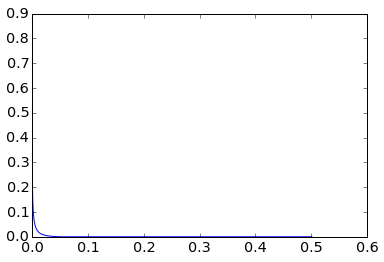

In [485]:

plot(1/test_D, pcorr[M_max_idx.astype(int)])

1.1325357117 3.39080668189


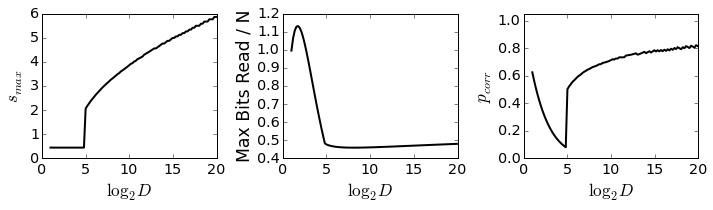

In [493]:
figure(figsize=(10,3))

subplot(131)
plot(np.log2(test_D), np.sqrt(N/M_max_idx), 'k', lw=2)
#ylim([0, 1.05])
xlabel('$\log_2 D$')
ylabel('$s_{max}$')

subplot(132)
plot(np.log2(test_D), info_max/N, 'k', lw=2)

imax_idx = np.argmax(info_max)

print info_max[imax_idx]/N, test_D[imax_idx]

xlabel('$\log_2 D$')
ylabel('Max Bits Read / N')

subplot(133)
plot(np.log2(test_D), pc_max, 'k', lw=2)
ylim([0.00001, 1.05])
xlabel('$\log_2 D$')
ylabel('$p_{corr}$')

plt.tight_layout()

savefig('figures/max_info-5N-pcorr-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/max_info-5N-pcorr-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

(0, 1.05)

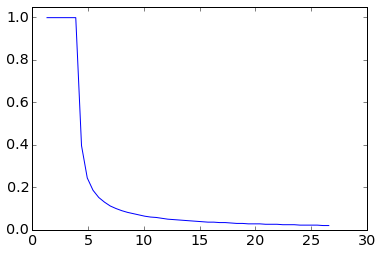

In [281]:
plot(np.log2(test_D), M_max_idx/N)
ylim([0, 1.05])

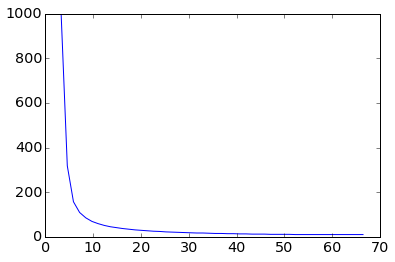

In [264]:
plot(np.log2(test_D), M_max_idx)